In [1]:
# Funciones importadas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import requests
import lxml.html as lh
from bs4 import BeautifulSoup
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier       
from sklearn import metrics
from sklearn.metrics import accuracy_score

### Importación de DataFrames obtenidos con scraping

In [2]:
# Definimos la funcion para leer los dos Dataframes obtenidos mediante scraping

def read_file(file):
    file = pd.read_csv(file)
    return file

In [3]:
# Abrimos los DataFrames que hemos obtenido del scraping

file = '../input/draft19_class.csv'
file2 = '../input/college_nba.csv'

draft19_class = read_file(file)
draft19_class.set_index(('Name'), inplace=True) # Columna 'Name' como indice
college_nbaplayers = read_file(file2)
college_nbaplayers.set_index(('Name'), inplace=True) # Columna 'Name' como indice                  

In [4]:
# Imprimimos los DataFrames para ver que todo está correcto

print('College stats of NBA players since 2000:')
display(college_nbaplayers.head())
print('College stats of NBA draft 2019 class:')
display(draft19_class.head())

College stats of NBA players since 2000:


,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,3P,...,STL,BLK,TOV,PF,PTS,SOS,ALLSTAR,YEAR,PK,POS
Name,,,,,,,,,,,,,,,,,,,,,
Salim Stoudamire,129.0,117.0,29.8,4.8,10.1,0.471,2.1,4.3,0.488,2.7,...,0.8,0.1,2.0,2.2,15.2,9.02,No,2005,31,Guard
Al Horford,109.0,100.0,25.7,3.9,6.6,0.586,3.9,6.6,0.589,0.0,...,0.9,1.7,1.6,2.5,10.3,6.65,Yes,2007,3,Center
Tony Allen,67.0,62.0,31.4,5.5,11.5,0.477,4.7,9.3,0.508,0.8,...,2.0,0.8,2.8,2.9,15.3,7.84,No,2004,25,Guard
Rasual Butler,110.0,60.0,38.3,6.8,16.7,0.409,4.3,9.6,0.447,2.6,...,1.0,1.1,2.7,1.8,19.3,3.11,No,2002,53,Forward
Jerami Grant,72.0,29.0,21.9,2.6,5.3,0.486,2.5,5.1,0.496,0.1,...,0.6,0.5,0.9,1.8,7.5,7.91,No,2014,39,Forward


College stats of NBA draft 2019 class:


,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,3P,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,SOS,POS
Name,,,,,,,,,,,,,,,,,,,,,
NICKEIL ALEXANDER-WALKER,67,67,29.9,4.7,10.1,0.464,3.0,5.6,0.529,1.7,...,3.4,4.0,2.7,1.4,0.5,2.2,1.9,13.5,7.25,Guard
R.J. BARRETT,38,38,35.3,8.4,18.5,0.454,6.5,12.2,0.529,1.9,...,6.0,7.6,4.3,0.9,0.4,3.2,1.8,22.6,11.97,Forward
TYUS BATTLE,103,94,35.4,5.3,12.8,0.417,3.6,7.6,0.474,1.7,...,2.3,2.8,2.1,1.3,0.2,1.8,2.0,16.0,9.52,Guard
BOL BOL,9,9,29.8,8.2,14.7,0.561,6.8,11.9,0.570,1.4,...,7.4,9.6,1.0,0.8,2.7,2.0,1.7,21.0,6.13,Center
MARQUES BOLDEN,88,24,13.6,1.5,2.6,0.573,1.5,2.5,0.591,0.0,...,1.9,3.3,0.4,0.3,1.1,0.6,1.6,3.8,10.86,Center


### Limpieza de DataFrames. Creación de dos archivos: uno para pronosticar AllStar y otro para pronosticar Draft

In [5]:
# Mediante este bucle for determinamos y creamos una columna si el jugador estuvo entre las 5 primeras selecciones de su draft.

top5=[]

for pick in college_nbaplayers['PK']: # PK es la columna que nos muestra en que pick (orden de selección) fue elegido el jugador
    if pick<=5:
        top5.append('Top5')
    else:
        top5.append('No')
        
college_nbaplayers['TOP-5'] = top5

In [6]:
# Al conseguir la columna 'TOP-5' las columnas 'Year' y 'PK'podemos eleiminarlas ya que no se usarán en el futuro

college_nbaplayers.drop(['YEAR'], axis=1, inplace=True)
college_nbaplayers.drop(['PK'], axis=1, inplace=True)

### Preparación de datos para aplicar modelos

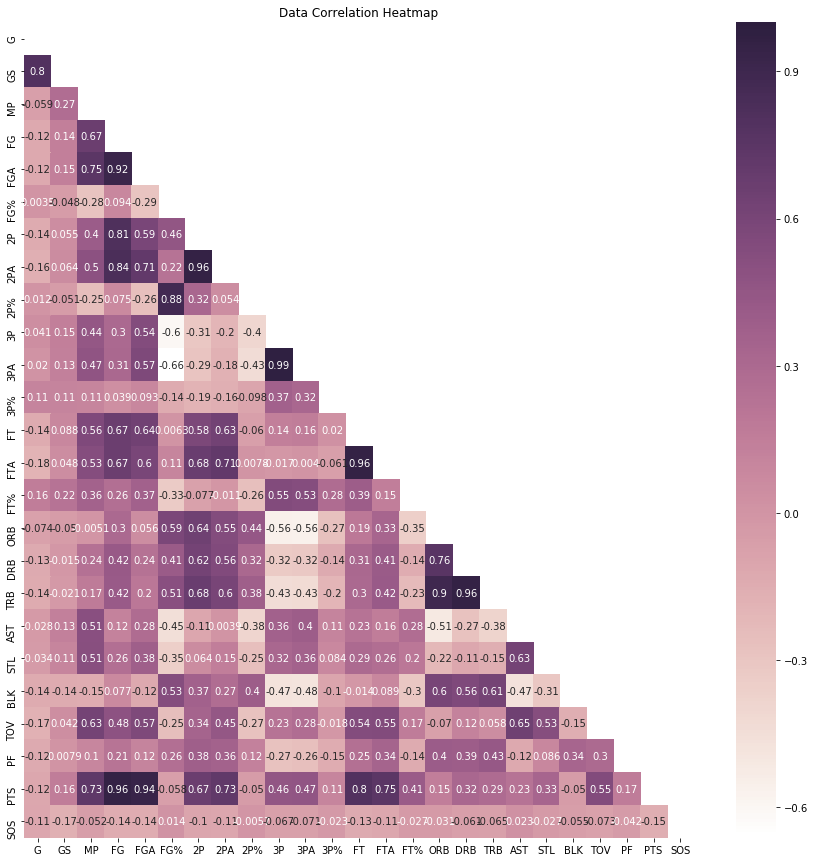

In [7]:
# Comprobamos la correlación entre columnas

corr = college_nbaplayers.corr()

# Generamos una mascara para el triangulo de arriba
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generamos la gráficas
fig, ax = plt.subplots(figsize=(15, 15))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, annot=True, cmap=cmap).set_title("Data Correlation Heatmap")


In [8]:
# Hacemos drop de las columnas que tienen correlación y representamos gráficamente de nuevo la matriz de correlación
# Nuestro parámetro de decisión es que si hay mas de un 0.8 de correlación, eliminamos la columna

drop_list= ['G', 'GS', 'FG', 'FGA', 'FG%', '2P', '3P', 'FT', 'ORB', 'DRB']

for i in drop_list:
    college_nbaplayers.drop([i], axis=1, inplace=True)

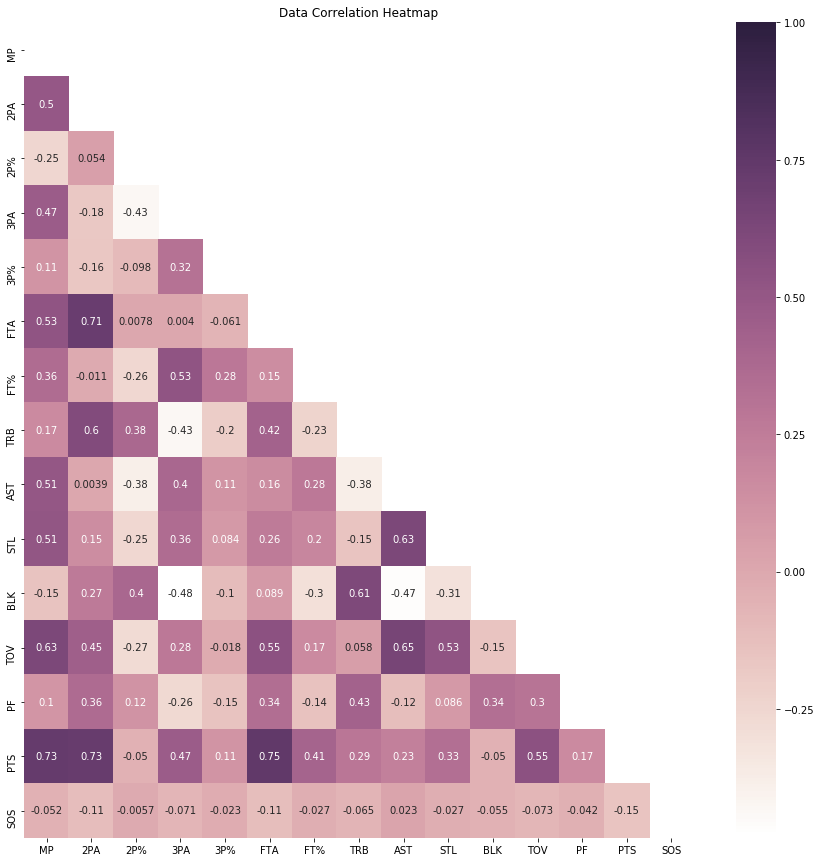

In [9]:
# Volvemos a crear la matriz de correlación de la misma manera que en el anterior paso

corr = college_nbaplayers.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15, 15))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, annot=True, cmap=cmap).set_title("Data Correlation Heatmap")


In [10]:
# Creamos dos modelos para nuestro análisis. Uno para entrenar y determinar si será All star y otro para saber si será un jugador elegido en el Top-5 del draft y otro para determinar si será jugador All star en su carrera
# Para cada modelo eliminamos la columna que nos sobra

all_star_college = college_nbaplayers.drop(['TOP-5'], axis=1)
top5_college = college_nbaplayers.drop(['ALLSTAR'], axis=1)


In [11]:
# Creamos dummies en ambos DataSet de cara a tener las posiciones del jugador en formato numerico

all_star_college = pd.get_dummies(all_star_college, drop_first=True)
top5_college = pd.get_dummies(top5_college, drop_first=True)


In [12]:
# Imprimimos los DataFrames para ver que todo está correcto

print('College stats of NBA players since 2000:')
display(all_star_college.head())
print('College stats of NBA draft 2019 class:')
display(top5_college.head())

College stats of NBA players since 2000:


,MP,2PA,2P%,3PA,3P%,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,SOS,ALLSTAR_Yes,POS_Forward,POS_Guard
Name,,,,,,,,,,,,,,,,,,
Salim Stoudamire,29.8,4.3,0.488,5.8,0.458,3.5,0.870,2.2,2.0,0.8,0.1,2.0,2.2,15.2,9.02,0,0,1
Al Horford,25.7,6.6,0.589,0.0,0.000,4.1,0.619,7.9,1.7,0.9,1.7,1.6,2.5,10.3,6.65,1,0,0
Tony Allen,31.4,9.3,0.508,2.2,0.347,5.2,0.682,5.5,2.9,2.0,0.8,2.8,2.9,15.3,7.84,0,0,1
Rasual Butler,38.3,9.6,0.447,7.1,0.359,3.7,0.829,5.9,1.6,1.0,1.1,2.7,1.8,19.3,3.11,0,1,0
Jerami Grant,21.9,5.1,0.496,0.3,0.300,3.5,0.641,4.7,0.9,0.6,0.5,0.9,1.8,7.5,7.91,0,1,0


College stats of NBA draft 2019 class:


,MP,2PA,2P%,3PA,3P%,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,SOS,POS_Forward,POS_Guard,TOP-5_Top5
Name,,,,,,,,,,,,,,,,,,
Salim Stoudamire,29.8,4.3,0.488,5.8,0.458,3.5,0.870,2.2,2.0,0.8,0.1,2.0,2.2,15.2,9.02,0,1,0
Al Horford,25.7,6.6,0.589,0.0,0.000,4.1,0.619,7.9,1.7,0.9,1.7,1.6,2.5,10.3,6.65,0,0,1
Tony Allen,31.4,9.3,0.508,2.2,0.347,5.2,0.682,5.5,2.9,2.0,0.8,2.8,2.9,15.3,7.84,0,1,0
Rasual Butler,38.3,9.6,0.447,7.1,0.359,3.7,0.829,5.9,1.6,1.0,1.1,2.7,1.8,19.3,3.11,1,0,0
Jerami Grant,21.9,5.1,0.496,0.3,0.300,3.5,0.641,4.7,0.9,0.6,0.5,0.9,1.8,7.5,7.91,1,0,0


In [13]:
# Hacemos drop de las columnas que había correlación también en el modelo de los candidatos a NBA 2019

for i in drop_list:
    draft19_class.drop([i], axis=1, inplace=True)
    
# Rellenamos las columnas que están vacias con la media del resto del draft

draft19_class['2P%'] = draft19_class['2P%'].fillna(draft19_class['2P%'].mean())
draft19_class['3P%'] = draft19_class['3P%'].fillna(draft19_class['3P%'].mean())
draft19_class['SOS'] = draft19_class['SOS'].fillna(draft19_class['SOS'].mean())
draft19_class = pd.get_dummies(draft19_class, drop_first=True)

draft19_class.columns

Index(['MP', '2PA', '2P%', '3PA', '3P%', 'FTA', 'FT%', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'SOS', 'POS_Forward', 'POS_Guard'],
      dtype='object')

In [14]:
# Quitamos de todos los modelos las columnas que no nos harán falta. En este caso 'SOS' (Strenght of Schedule) ya que es muy sensible ante sorpresas previas y durante el March Madness

all_star_college.drop(['SOS'], axis=1, inplace=True)
top5_college.drop(['SOS'], axis=1, inplace=True)
draft19_class.drop(['SOS'], axis=1, inplace=True)


### Exportación de archivos a un csv

In [15]:
# Guardamos todos los DataSets

all_star_college.to_csv('../input/model_dummies_allstar.csv', index=True)
top5_college.to_csv('../input/model_dummies_college_nba.csv', index=True)
draft19_class.to_csv('../input/model_draft19_class.csv', index=True)